In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('dataset-merged.csv')
df.columns

Index(['sr', 'text', 'label', 'wcount'], dtype='object')

In [4]:
df.drop(columns=['sr'], inplace=True)

In [5]:
df.isna().sum()

text      1
label     0
wcount    0
dtype: int64

In [6]:
df = df.dropna()

In [7]:
df.head()

,text,label,wcount
0,‘मोदी के शासन के दौरान गंगा’ गंगा नदी नरेन्द्...,1,19
1,यह खबर आने से पहले छवि क्रेडिट जस्टिन सुलिवान/...,1,374
2,गुलाब गेंद वाल डे-नाइट टेस्ट मैच कप्ता विराट क...,0,20
3,उत्तर कोरिया रॉकेट प्रक्षेपण योजनाएं 71 0 15 0...,1,345
4,राष्ट्रपति डोनाल्ड ट्रम्प और प्रथम महिला मेलान...,0,180


In [8]:
import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer

In [9]:
hindi_stopwords = set(["के", "का", "में", "की", "है", "यह", "और", "से", "हैं", "को", "पर", "इस", "होता", "कि", "जो", "भी", "और", "नहीं", "तो", "ही", "या", "लेकिन", "व", "अपने", "ने", "तरह", "हो", "रहा", "जब", "का", "रहे", "किया", "उस", "था", "थे", "किए", "सकता", "रखें", "होती", "रखना", "लिए"])

In [10]:
def clean_text(text):
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove stop words
    text = ' '.join(word for word in text.split() if word not in hindi_stopwords)
    return text

In [11]:
df['clean_text'] = df['text'].apply(clean_text)

In [12]:
# Initialize TF-IDF Vectorizer with parameters suited for mixed language text
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), analyzer='word')

In [13]:
# Fit and transform the text data
X_tfidf = tfidf.fit_transform(df['clean_text']).toarray()

In [14]:
# Combine TF-IDF features with the word count feature
X = pd.concat([pd.DataFrame(X_tfidf), df['wcount'].reset_index(drop=True)], axis=1)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,4991,4992,4993,4994,4995,4996,4997,4998,4999,wcount
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,374
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,345
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,180


In [15]:
# Labels
y = df['label']

In [16]:
from sklearn.model_selection import train_test_split

# lets divide our data into train, test and validation.
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [17]:
# Convert column names to string type
X_train.columns = X_train.columns.astype(str)
X_val.columns = X_val.columns.astype(str)
X_test.columns = X_test.columns.astype(str)

In [18]:
print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}, Testing samples: {X_test.shape[0]}")

Training samples: 13698, Validation samples: 1712, Testing samples: 1713


In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Instantiate the RandomForestClassifier with your chosen hyperparameters
rf_model = RandomForestClassifier(n_estimators=200, 
                                  max_features='sqrt', 
                                  max_depth=10, 
                                  min_samples_split=5, 
                                  min_samples_leaf=1, 
                                  random_state=42)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_rf = rf_model.predict(X_val)

# Evaluate the model on the validation set
val_accuracy_rf = accuracy_score(y_val, y_val_pred_rf)
val_classification_rep_rf = classification_report(y_val, y_val_pred_rf)

print("Random Forest Classifier Validation Results:")
print(f"Validation Accuracy: {val_accuracy_rf}")
print("Validation Classification Report:")
print(val_classification_rep_rf)


Random Forest Classifier Validation Results:
Validation Accuracy: 0.7342289719626168
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.96      0.81       990
           1       0.88      0.43      0.58       722

    accuracy                           0.73      1712
   macro avg       0.79      0.69      0.69      1712
weighted avg       0.77      0.73      0.71      1712



In [25]:
!pip install xgboost

   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/124.9 MB 217.9 kB/s eta 0:09:34
   ---------------------------------------- 0.1/124.9 MB 409.6 kB/s eta 0:05:05
   ---------------------------------------- 0.3/124.9 MB 1.6 MB/s eta 0:01:18
   ---------------------------------------- 0.6/124.9 MB 2.5 MB/s eta 0:00:50
   ---------------------------------------- 0.9/124.9 MB 3.2 MB/s eta 0:00:39
   ---------------------------------------- 1.1/124.9 MB 3.6 MB/s eta 0:00:35
   ---------------------------------------- 1.3/124.9 MB 3.7 MB/s eta 0:00:34
    --------------------------------------- 1.6/124.9 MB 4.1 MB/s eta 0:00:30
    --------------------------------------- 1.9/124.9 MB 4.3 MB/s eta 0:00:29
    --------------------------------------- 2.3/124.9 MB 4.5 MB/s eta 0:00:28
   

In [29]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

params = {
    'n_estimators': 300,
    'max_depth': 6,
    'objective': 'binary:logistic',  # For binary classification
    'learning_rate': 0.1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'tree_method': 'hist',  # Use histogram-based method
    'device': 'gpu',  # Use GPU for training
    'eval_metric': 'error'  # Evaluation metric
}


bst = xgb.train(params, dtrain, num_boost_round=200, evals=[(dval, 'validation')], early_stopping_rounds=10)

y_val_pred_xgb = bst.predict(dval)
y_val_pred_xgb_binary = [round(pred) for pred in y_val_pred_xgb]  # Convert to binary predictions if needed

val_accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb_binary)
val_classification_rep_xgb = classification_report(y_val, y_val_pred_xgb_binary)

print("XGBoost Classifier Validation Results:")
print(f"Validation Accuracy: {val_accuracy_xgb}")
print("Validation Classification Report:")
print(val_classification_rep_xgb)


c:\Users\SAM\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:58:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation-error:0.42173
[1]	validation-error:0.34521
[2]	validation-error:0.26227
[3]	validation-error:0.24825
[4]	validation-error:0.23657
[5]	validation-error:0.23773
[6]	validation-error:0.23481
[7]	validation-error:0.23423
[8]	validation-error:0.23248
[9]	validation-error:0.22722
[10]	validation-error:0.22780
[11]	validation-error:0.22956
[12]	validation-error:0.22547
[13]	validation-error:0.22547
[14]	validation-error:0.22488
[15]	validation-error:0.22138
[16]	validation-error:0.21904
[17]	validation-error:0.21612
[18]	validation-error:0.21379
[19]	validation-error:0.21554
[20]	validation-error:0.21612
[21]	validation-error:0.21554
[22]	validation-error:0.21554
[23]	validation-error:0.21495
[24]	validation-error:0.21379
[25]	validation-error:0.21262
[26]	validation-error:0.21145
[27]	validation-error:0.21203
[28]	validation-error:0.21086
[29]	validation-error:0.21145
[30]	validation-error:0.20794
[31]	validation-error:0.20911
[32]	validation-error:0.20853
[33]	validation-erro

In [30]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report

# Instantiate the GradientBoostingClassifier with your chosen hyperparameters
gb_model = GradientBoostingClassifier(n_estimators=200,
                                      learning_rate=0.1,
                                      max_depth=5,
                                      min_samples_split=2,
                                      min_samples_leaf=1,
                                      random_state=42)

# Fit the model to the training data
gb_model.fit(X_train, y_train)

# Predict on the validation set
y_val_pred_gb = gb_model.predict(X_val)

# Evaluate the model on the validation set
val_accuracy_gb = accuracy_score(y_val, y_val_pred_gb)
val_classification_rep_gb = classification_report(y_val, y_val_pred_gb)

print("Gradient Boosting Classifier Validation Results:")
print(f"Validation Accuracy: {val_accuracy_gb}")
print("Validation Classification Report:")
print(val_classification_rep_gb)


Gradient Boosting Classifier Validation Results:
Validation Accuracy: 0.8095794392523364
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.91      0.85       990
           1       0.85      0.67      0.75       722

    accuracy                           0.81      1712
   macro avg       0.82      0.79      0.80      1712
weighted avg       0.81      0.81      0.81      1712



Random Forest Classifier Test Results:
Test Accuracy: 0.7238762405137186
Test Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.95      0.80       995
           1       0.86      0.41      0.55       718

    accuracy                           0.72      1713
   macro avg       0.78      0.68      0.68      1713
weighted avg       0.76      0.72      0.70      1713



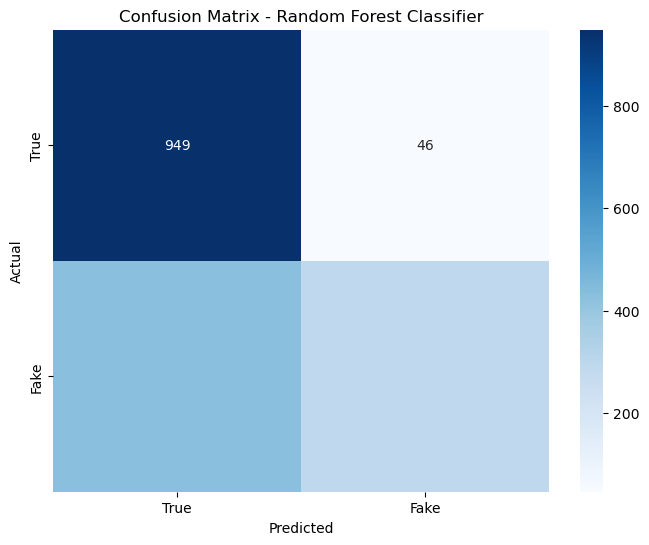

Gradient Boosting Classifier Test Results:
Test Accuracy: 0.801517805020432
Test Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.93      0.84       995
           1       0.86      0.63      0.73       718

    accuracy                           0.80      1713
   macro avg       0.82      0.78      0.79      1713
weighted avg       0.81      0.80      0.79      1713



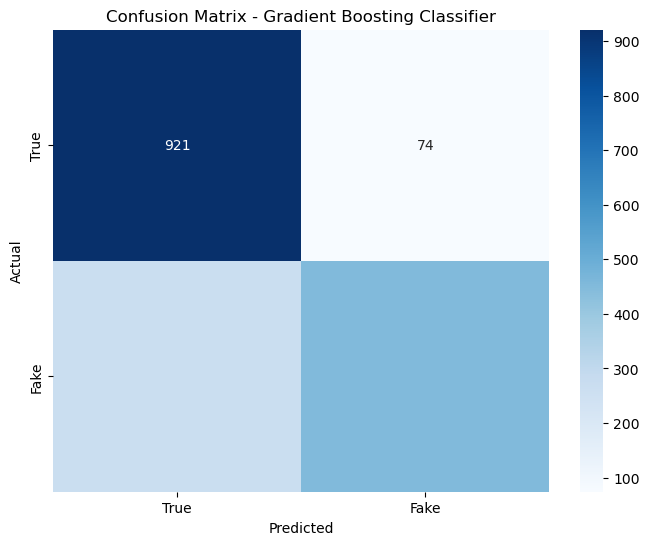

In [35]:
from sklearn.metrics import confusion_matrix

# Function to evaluate model on test set and generate plots
def evaluate_model(model, X_test, y_test, model_name):
    # Predict on the test set
    y_test_pred = model.predict(X_test)

    # Evaluate the model on the test set
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_classification_rep = classification_report(y_test, y_test_pred)

    print(f"{model_name} Test Results:")
    print(f"Test Accuracy: {test_accuracy}")
    print("Test Classification Report:")
    print(test_classification_rep)

    # Confusion matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['True', 'Fake'], yticklabels=['True', 'Fake'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

evaluate_model(rf_model, X_test, y_test, "Random Forest Classifier")

evaluate_model(gb_model, X_test, y_test, "Gradient Boosting Classifier")



XGBoost Classifier Test Results:
Test Accuracy: 0.7997664915353182
Test Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       995
           1       0.87      0.61      0.72       718

    accuracy                           0.80      1713
   macro avg       0.82      0.77      0.78      1713
weighted avg       0.81      0.80      0.79      1713



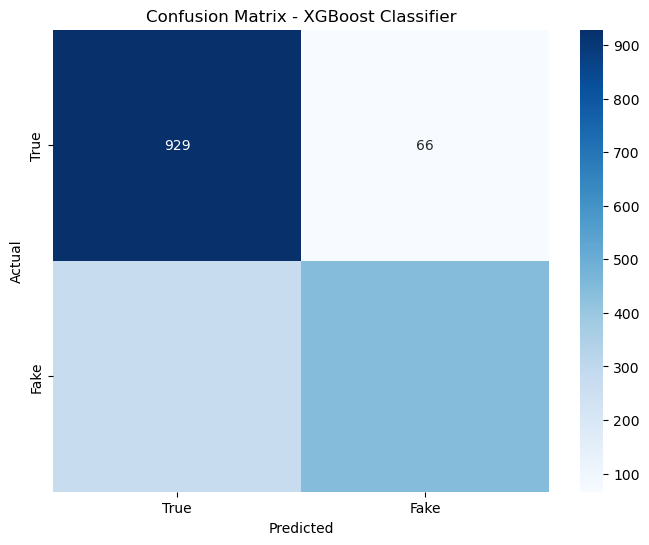

In [36]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming X_test and y_test are defined
dtest = xgb.DMatrix(X_test, label=y_test)

# Predict on the test set
y_test_pred = bst.predict(dtest)
y_test_pred_binary = [round(pred) for pred in y_test_pred]  # Convert to binary predictions if needed

# Evaluate the model on the test set
test_accuracy = accuracy_score(y_test, y_test_pred_binary)
test_classification_rep = classification_report(y_test, y_test_pred_binary)

print("XGBoost Classifier Test Results:")
print(f"Test Accuracy: {test_accuracy}")
print("Test Classification Report:")
print(test_classification_rep)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_test_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['True', 'Fake'], yticklabels=['True', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - XGBoost Classifier')
plt.show()
